In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = torchvision.datasets.MNIST(root='./data',
                                           transform = transforms.ToTensor(),
                                           train=True,
                                           download = True)

test_dataset = torchvision.datasets.MNIST(root = './data',
                                          transform = transforms.ToTensor(),
                                          train = False,
                                          download = True)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = 64,
                                           shuffle = True,
                                           drop_last = True) # Batch_size, channel_size, height, width

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = 64,
                                          shuffle = False,
                                          drop_last = True)



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.04MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 242kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.87MB/s]


In [ ]:
sample = iter(train_loader)
images,labels = next(sample)
print(images.shape)

torch.Size([64, 1, 28, 28])


### The encoder and decoder network is preety same as that of autoencoder. The whole concept introduced in variational autoencoder is the reparamaterization trick. If we just sample our latent (z) from normal distribution with calculated mean and variance, we cant do the backpropagation, cause this step is stochastic and not deterministic. so we use the property or shifting and scaling of normal distribution and sample a random noise from standard distribution and then shift by mean and scale by standard deviation.

In [ ]:
# linear variational autoencoder

class Linearvariationalautoencoder(nn.Module):

  def __init__(self,latent_dim=2):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Linear(28*28,128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,28)
    )

    self.decoder = nn.Sequential(
        nn.Linear(latent_dim,64),
        nn.ReLU(),
        nn.Linear(64,128),
        nn.ReLU(),
        nn.Linear(128,28*28),
        nn.Sigmoid()
    )

    self.mu = nn.Linear(28, latent_dim)
    self.logvar = nn.Linear(28, latent_dim)

  def forward_encoder(self,x):
    x = x.flatten(1)
    return self.encoder(x)

  def forward_decoder (self,x):
    return self.decoder(x)

  def forward(self,x):
    x = self.forward_encoder(x)

    mu = self.mu(x)
    logvar = self.logvar(x)
    std = torch.exp(0.5 *logvar)

    noise = torch.randn_like(std,device = std.device)
    z = mu + noise * std

    x_hat = self.forward_decoder(z)
    x_hat = x_hat.reshape(-1,1,28,28)
    return z,x_hat,mu,logvar

model = Linearvariationalautoencoder(2).to(device)
model

Linearvariationalautoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=28, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Sigmoid()
  )
  (mu): Linear(in_features=28, out_features=2, bias=True)
  (logvar): Linear(in_features=28, out_features=2, bias=True)
)

In [ ]:
test_x = torch.rand([64,1,28,28]).to(device)
x_hat,mu,logvar = model(test_x)
print(x_hat.shape)
print(mu.shape)
print(logvar.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 2])
torch.Size([64, 2])


### loss
The problem with average mean square pixel loss is that when we have huge no of pixels the loss is very less so might cause some issues in backpropagation and vanishing problems. rather we should go with average mean square image loss where we calculate the sum all errors of all the pixels and find the image loss and then take the mean of all the images in the batch.

In [2]:
def var_loss(x,x_hat,log_var,mu,reconstruction_weight=1,kl_weight=1):

  """ here we calculate the average mean squared error on image level i.e we calculate the pixel loss for each image
  flatten it sum that up to find the total image loss and then take the mean over the entire batch and find the reconstruction loss for the batch
  similarly we do the same for kl loss"""

  pixel_mse = (x-x_hat)**2 # b,c,h,w
  pixel_flat_mse = pixel_mse.flatten(1)
  #reconstruction_loss = pixel_flat_mse.mean()
  reconstruction_loss = pixel_flat_mse.sum(axis = -1).mean()
  #print("reconstruction loss :",reconstruction_loss)

  # kl loss
  kl = (1 + log_var - mu**2 - torch.exp(log_var)).flatten(1)
  kl_loss_per_img = -0.5 * kl.sum(axis = -1)
  kl_loss = kl_loss_per_img.mean()
  #print("kl loss :",kl_loss)

  return reconstruction_weight *reconstruction_loss + kl_weight * kl_loss

In [ ]:
test_x = torch.rand(4,3,4,4)
test_x_hat = torch.rand(4,3,4,4)
test_mu = torch.rand(4,2)
test_logvar = torch.rand(4,2)
total_loss = var_loss(test_x,test_x_hat,test_logvar,test_mu,1,1)
print(total_loss)
print(test_mu)
print(test_mu[-1])
print(torch.cat((test_mu,test_logvar),axis = -1).shape)

tensor(0.7103)
tensor([[0.9634, 0.5895],
        [0.6997, 0.4950],
        [0.6691, 0.4683],
        [0.5023, 0.3454]])
tensor([0.5023, 0.3454])
torch.Size([4, 4])


In [3]:
from tqdm.notebook import tqdm
import numpy as np

def train(model,
          train_loader,
          test_loader,
          batch_size,
          kl_weight,
          epochs,
          evaluation_iteration,
          model_type="VAE"):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_losses = []
    eval_losses = []
    encoded_data_per_eval = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):

        train_loss = []
        model.train()  # Set model to train mode

        for images, labels in train_loader:
            images = images.to(device)

            if model_type == "VAE":
                encoded_images, decoded_images, mu, logvar = model(images)
                loss = var_loss(images, decoded_images, logvar, mu,kl_weight=kl_weight)
            else:
                encoded_images, decoded_images = model(images)
                loss = var_loss(images, decoded_images, None, None)

            train_loss.append(loss.item())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # 🔧 Now evaluation happens once per epoch, not after every batch
        if epoch % evaluation_iteration == 0:
            model.eval()
            eval_loss = []
            encoded_evaluations = []

            with torch.no_grad():
                for images, labels in test_loader:
                    images = images.to(device)

                    if model_type == "VAE":
                        encoded_images, decoded_images, mu, logvar = model(images)
                        loss = var_loss(images, decoded_images, logvar, mu,kl_weight=kl_weight)
                    else:
                        encoded_images, decoded_images = model(images)
                        loss = var_loss(images, decoded_images, None, None)

                    eval_loss.append(loss.item())
                    encoded = encoded_images.to('cpu').flatten(1)
                    labels = labels.reshape(-1, 1)
                    encoded_evaluations.append(torch.cat((encoded, labels), axis=-1))

                encoded_data_per_eval.append(torch.cat(encoded_evaluations).detach())
                eval_losses.append(np.mean(eval_loss))

        train_losses.append(np.mean(train_loss))

    print("training completed !!!")
    print("final training loss ", train_losses[-1])
    print("final mean",mu[-1])
    print("final logvar",logvar[-1])
    if eval_losses:
        print("final evaluation loss ", eval_losses[-1])

    return model, train_losses, eval_losses, encoded_data_per_eval


In [ ]:
models = []
encoded_datas = []

# # training variational autoencoder across multiple kl weights
kl_weights = [1,100]
for kl_weight in kl_weights:
  model , train_losses,evaluation_losses,encoded_data_per_eval = train(model,train_loader,test_loader,64,kl_weight,51,5,"VAE")
  models.append(model)
  encoded_datas.append(encoded_data_per_eval)

Training Epochs:   0%|          | 0/51 [00:00<?, ?it/s]

training completed !!!
final training loss  42.43076693719072
final mean tensor([-2.4422, -0.1781], device='cuda:0')
final logvar tensor([-3.6078, -3.0034], device='cuda:0')
final evaluation loss  42.58501691084642


Training Epochs:   0%|          | 0/51 [00:00<?, ?it/s]

training completed !!!
final training loss  52.734181378668886
final mean tensor([-0.0007,  0.0026], device='cuda:0')
final logvar tensor([-0.0004, -0.0018], device='cuda:0')
final evaluation loss  52.9000127743452


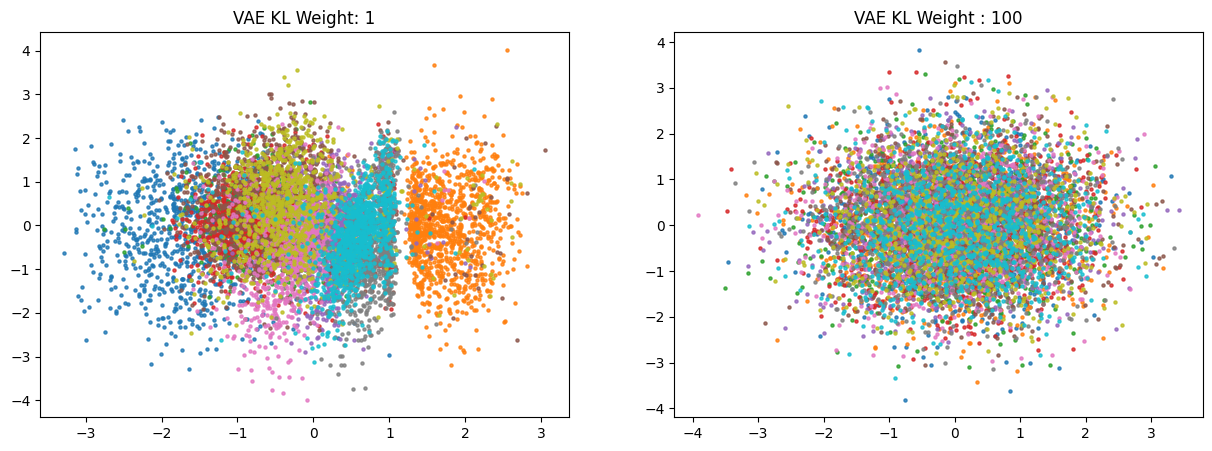

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

model_latents = [x[-1] for x in encoded_datas]
model_names = ["VAE KL Weight: 1","VAE KL Weight : 100"]

fig, ax = plt.subplots(1,2, figsize=(15,5))

for idx, encoding in enumerate(model_latents):
    encoding = pd.DataFrame(encoding, columns=["x", "y", "class"])
    encoding = encoding.sort_values(by="class")
    encoding["class"] = encoding["class"].astype(int).astype(str)

    for grouper, group in encoding.groupby("class"):
        ax[idx].scatter(x=group["x"], y=group["y"], label=grouper, alpha=0.8, s=5)
        ax[idx].set_title(model_names[idx])

torch.Size([1, 2])
tensor([[-0.3080,  0.5866]], device='cuda:0')
(28, 28)


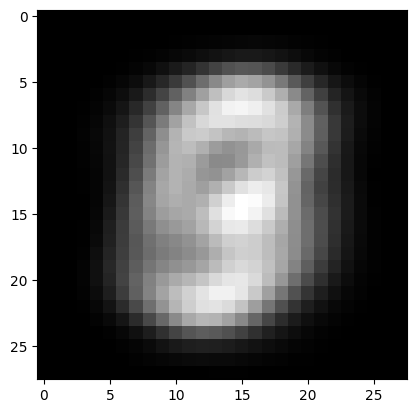

In [ ]:
# generating new samples
sample = torch.randn((1,2)).to(device)
#sample = torch.tensor([1.5,2.5]).reshape(1,2).type(torch.float32).to(device)
print(sample.shape)
vae1,va100 = models
model  = va100.to(device)
with torch.no_grad():
  print(sample)
  generation = model.forward_decoder(sample).to('cpu')

generation = generation.detach().numpy().reshape(28,28)
print(generation.shape)
plt.imshow(generation,cmap='gray')

In [24]:
# implementing convolution variational autoencoder
import torch.nn as nn
import torch

class conv_variational_autoencoder(nn.Module):

  def __init__(self,in_channels=1,bottleneck=2):
    super().__init__()

    self.in_channels = in_channels
    self.bottleneck = bottleneck

    self.encoder = nn.Sequential(

                  nn.Conv2d(in_channels=in_channels,out_channels = 8,kernel_size = 3,stride = 2,padding = 1), #28 x 28 x1--> 14 x 14 x8
                  nn.ReLU(),

                  nn.Conv2d(in_channels=8,out_channels = 16,kernel_size = 3,stride = 2,padding = 1), #14 x 14 x8--> 7 x 7 x16
                  nn.ReLU(),

                  nn.Conv2d(in_channels=16,out_channels = 32,kernel_size = 3,stride = 2,padding = 1), #7 x 7 x16--> 4 x 4 x32


    )

    self.mu = nn.Conv2d(in_channels = 32, out_channels = bottleneck, kernel_size = 1,stride=1,padding=0)
    self.logvar = nn.Conv2d(in_channels = 32, out_channels = bottleneck, kernel_size = 1,stride=1,padding=0)

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d (in_channels = bottleneck, out_channels = 32, kernel_size = 3, stride = 2, padding = 1,output_padding=0), #2 x 4 x 4--> 32 x 7 x 7
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = 3, stride = 2, padding = 1,output_padding=1), # 32 x 8 x 8 -> 16 x 14 x 14
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels = 16, out_channels = 8, kernel_size = 3, stride = 2, padding = 1,output_padding=1), #16 x 16 x 16 -> 8 x 28 x 28
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels = 8, out_channels = 1, kernel_size = 3, stride = 1, padding = 1,output_padding=0), # channel reduced to 1
        nn.Sigmoid()
    )


  def forward_enc(self,x):
    return self.encoder(x)

  def forward_dec(self,x):
    return self.decoder(x)

  def forward(self,x):
    x = self.forward_enc(x)

    mu = self.mu(x)
    logvar = self.logvar(x)

    std = torch.exp(0.5 * logvar)
    noise = torch.randn_like(std,device = std.device)
    z = mu + noise * std

    x_hat = self.forward_dec(z)
    return z,x_hat,mu,logvar

conv_model = conv_variational_autoencoder(1,2)
conv_model

conv_variational_autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (mu): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
  (logvar): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
  (decoder): Sequential(
    (0): ConvTranspose2d(2, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Sigmoid()
  )
)

In [8]:
test_x = torch.rand((64,1,28,28))
z,x_hat,mu,logvar = conv_model(test_x)
print(z.shape)
print(x_hat.shape)
print(mu.shape)
print(logvar.shape)

torch.Size([64, 2, 4, 4])
torch.Size([64, 1, 28, 28])
torch.Size([64, 2, 4, 4])
torch.Size([64, 2, 4, 4])


In [39]:
# train the conv vae
model , train_losses,evaluation_losses,encoded_data_per_eval = train(conv_model,train_loader,test_loader,64,1,11,5,"VAE")


Training Epochs:   0%|          | 0/11 [00:00<?, ?it/s]

training completed !!!
final training loss  44.18255768310807
final mean tensor([[[-0.0506, -0.0773,  0.0704,  0.1781],
         [-0.0220,  1.8013, -1.5156, -0.9144],
         [ 0.3549, -0.5632,  1.9532, -1.4857],
         [-0.0855, -0.5030, -1.5228, -0.2614]],

        [[-0.2264, -0.4137, -0.4951, -0.4766],
         [-0.4173,  1.7227,  1.9842,  0.6587],
         [-0.8431,  1.5729,  0.0744, -0.2541],
         [-1.1817,  0.8111,  1.1333, -1.2121]]], device='cuda:0')
final logvar tensor([[[-0.0971, -0.4630, -0.3760, -0.0737],
         [-0.2846, -2.5137, -2.7223, -2.7985],
         [-0.3716, -2.9369, -1.9793, -2.3961],
         [-0.4648, -2.6396, -2.8985, -1.9855]],

        [[-0.2566, -0.5912, -0.8046, -0.4339],
         [-0.5209, -1.9615, -2.0402, -1.9315],
         [-1.2684, -1.6845, -2.3253, -1.6983],
         [-0.7622, -2.4258, -2.0422, -0.7064]]], device='cuda:0')
final evaluation loss  43.971709104684685


(28, 28)


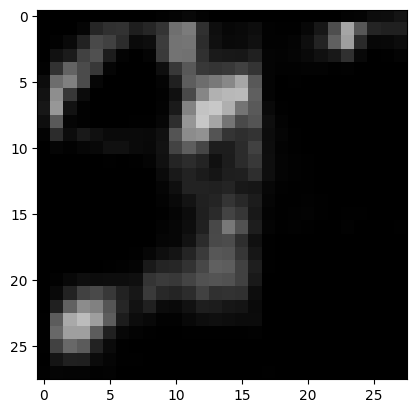

In [40]:
# generation
import matplotlib.pyplot as plt
sample = torch.randn((1,2,4,4)).to(device)
model.to(device)
with torch.no_grad():
  generation = model.forward_dec(sample).to('cpu')

generation = generation.detach().numpy().reshape(28,28)
print(generation.shape)
plt.imshow(generation, cmap='gray',vmin=0, vmax=1)

### one problem that we again come across in VAEs is that the reconstructed images are often blury.

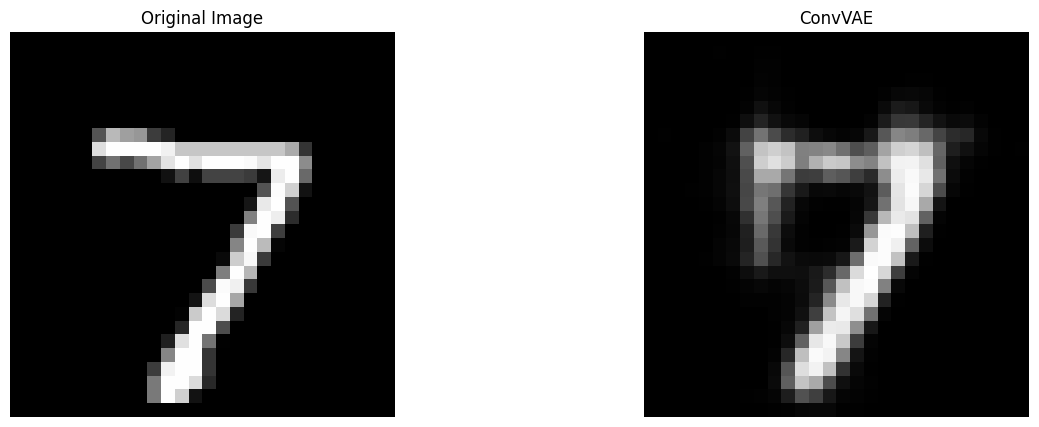

In [41]:
generated_index = 0
image, label = test_dataset[generated_index]
image = image.unsqueeze(0).to(device)

_, conv_vae_reconstructed, _, _ = model(image)
conv_vae_reconstructed = conv_vae_reconstructed.to("cpu").detach().numpy()

image = image.to("cpu")

fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].imshow(image.squeeze(), cmap="gray")
ax[0].set_title("Original Image")
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].axis("off")

ax[1].imshow(conv_vae_reconstructed.squeeze(), cmap="gray")
ax[1].set_title("ConvVAE")
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].axis("off")


plt.show()


#### To eliminate this problem we have vector quantized VAEs.